<a href="https://colab.research.google.com/github/shreyasrajesh0308/Deep_Learning_Fchollet/blob/master/Consolidated_CORA_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project-2 Part3

Contains all the consolidated codes for the CORA dataset, we run it all in one notebook to make data split consistent and comparison between techniques easier. 


## Function imports

In [ ]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

     |████████████████████████████████| 374 kB 4.2 MB/s 
     |████████████████████████████████| 482 kB 46.8 MB/s 
     |████████████████████████████████| 462 kB 48.7 MB/s 
     |████████████████████████████████| 41 kB 343 kB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None


In [ ]:
#Data Prep libraries
import pandas as pd
import os

#Building GCN layers
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

#Train network and run inference
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Load the CORA dataset

In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()


In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)


In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [ ]:
cats = ["Neural_Networks", "Probabilistic_Methods", "Genetic_Algorithms", "Theory", "Case_Based", "Reinforcement_Learning", "Rule_Learning"]

train_subjects = pd.Series()
test_subjects = pd.Series()

for cat in cats:
  train_subjects = train_subjects.append(node_subjects.loc[node_subjects == cat][:20])
  test_subjects = test_subjects.append(node_subjects.loc[node_subjects == cat][20:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [ ]:
from sklearn.utils import shuffle
train_subjects = shuffle(train_subjects)
test_subjects = shuffle(test_subjects)

In [ ]:
train_subjects.value_counts().to_frame()

,0
Reinforcement_Learning,20
Neural_Networks,20
Case_Based,20
Theory,20
Genetic_Algorithms,20
Probabilistic_Methods,20
Rule_Learning,20


In [ ]:
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

## Convert Targets to one hot encoding

In [ ]:
# Creating a label binarizer which converts labels to one hot encoding.
target_encoding = preprocessing.LabelBinarizer()

# Train, val and test targets
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

## GCN Implementation.

Implementation of the GCN algorithm, we use the stellargraph implementation of GCN.

GCN paper - https://arxiv.org/abs/1609.02907

Stellargraph documentation - https://stellargraph.readthedocs.io/en/v1.0.0rc1/index.html

### Creating the GCN layer

In [ ]:
# Create a data generator
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
# Create trainable object
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
# Trainable model 
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
predictions

<KerasTensor: shape=(1, None, 7) dtype=float32 (created by layer 'dense')>

### Training and evaluating

In [ ]:
# Build the Keras Model
model = Model(inputs=x_inp, outputs=predictions)

# Compile model 
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Create Valid data
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
# Early stopping keras
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
# Model training
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)


Epoch 1/200
1/1 - 1s - loss: 1.9509 - acc: 0.1000 - val_loss: 1.9374 - val_acc: 0.2900 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 1.9186 - acc: 0.3286 - val_loss: 1.9039 - val_acc: 0.4800 - 152ms/epoch - 152ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8668 - acc: 0.5714 - val_loss: 1.8493 - val_acc: 0.5480 - 149ms/epoch - 149ms/step
Epoch 4/200
1/1 - 0s - loss: 1.8116 - acc: 0.5571 - val_loss: 1.7844 - val_acc: 0.5880 - 152ms/epoch - 152ms/step
Epoch 5/200
1/1 - 0s - loss: 1.7159 - acc: 0.5857 - val_loss: 1.7155 - val_acc: 0.6160 - 189ms/epoch - 189ms/step
Epoch 6/200
1/1 - 0s - loss: 1.6562 - acc: 0.6643 - val_loss: 1.6449 - val_acc: 0.6440 - 157ms/epoch - 157ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5518 - acc: 0.6500 - val_loss: 1.5778 - val_acc: 0.6540 - 153ms/epoch - 153ms/step
Epoch 8/200
1/1 - 0s - loss: 1.4585 - acc: 0.6786 - val_loss: 1.5108 - val_acc: 0.6720 - 153ms/epoch - 153ms/step
Epoch 9/200
1/1 - 0s - loss: 1.3376 - acc: 0.6786 - val_loss: 1.4451 - val_acc: 0.6900 - 147ms

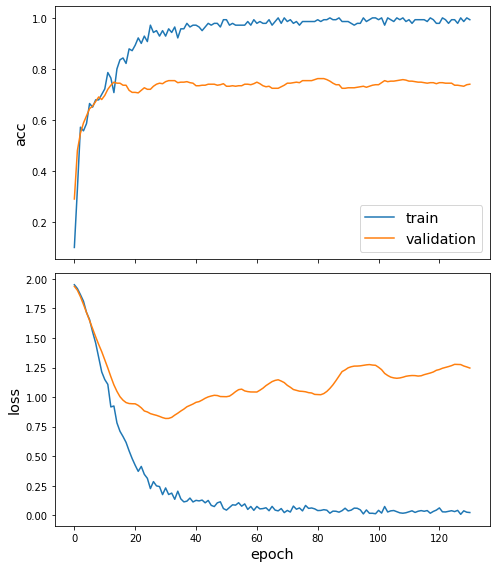

In [ ]:
sg.utils.plot_history(history)

In [ ]:
# Create the test generator 
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 68ms/step - loss: 1.0165 - acc: 0.7611

Test Set Metrics:
	loss: 1.0165
	acc: 0.7611


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
# Convert to required form
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Theory,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


### Node Embeddings

In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)


In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [ ]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [ ]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

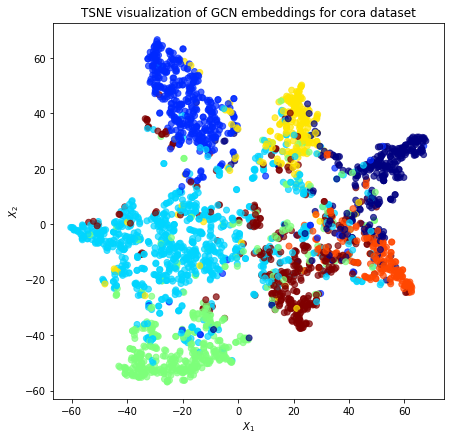

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)


## Node2Vec

### Creating the random walk

In [ ]:
from stellargraph.data import BiasedRandomWalk


In [ ]:
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 27080


### Representation learning using Word2Vec

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)


In [ ]:
model.wv.vectors.shape

(2708, 128)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(128,)

### Visualise Node Embeddings

Visualize the node embeddings by performing dim reduction using TSNE. 

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [ ]:
node_embeddings.shape

(2708, 128)

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


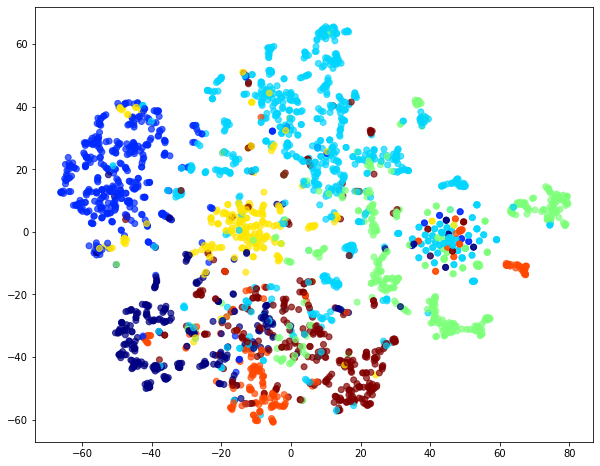

In [ ]:
import numpy as np 

# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

### Downstream task

In [ ]:
y_train = []
X_train = []
y_test = []
X_test = []
y_valid = []
X_valid = []

In [ ]:
test_subjects.shape

(2068,)

In [ ]:
# 1433 dimensional vectors
X_dimvecs = G.node_features(nodes = G.nodes())

X_train_dimvecs = []
X_test_dimvecs = []

In [ ]:
for i, l in enumerate(node_targets.index):
  
  if l in train_subjects.index:
    X_train.append(node_embeddings[i])
    y_train.append(node_targets[l])
    X_train_dimvecs.append(X_dimvecs[i])
  elif l in val_subjects.index:
    X_valid.append(node_embeddings[i])
    y_valid.append(node_targets[l])
  else:
    X_test.append(node_embeddings[i])
    y_test.append(node_targets[l])
    X_test_dimvecs.append(X_dimvecs[i])


In [ ]:
assert len(X_train) == train_subjects.shape[0]
assert len(X_valid) == val_subjects.shape[0]
assert len(X_test) == test_subjects.shape[0]
assert len(X_train) == len(X_train_dimvecs)
assert len(X_test) == len(X_test_dimvecs)

In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)
X_train_dimvecs = np.array(X_train_dimvecs)
X_test_dimvecs = np.array(X_test_dimvecs)

In [ ]:
y_test.shape

(2068,)

## Classifier Training with Logistic Regression

Example here training a logistic regressor, remember to change this to random forest. 

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score


In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)


0.6499032882011605

## Classifier Training with Random Forests

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model 
clf.fit(X_train,y_train)

# Perform Predictions
y_pred=clf.predict(X_test)


In [ ]:
accuracy_score(y_test, y_pred)


0.6648936170212766

## Classifier Training with Logistic Regression with just dimensions vector

Example here training a logistic regressor, remember to change this to random forest. 

In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train_dimvecs, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [ ]:
y_pred = clf.predict(X_test_dimvecs)

In [ ]:
accuracy_score(y_test, y_pred)


0.1513539651837524

## Classifier Training with Random Forests with dim vectors

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model 
clf.fit(X_train_dimvecs,y_train)

# Perform Predictions
y_pred=clf.predict(X_test_dimvecs)


In [ ]:
accuracy_score(y_test, y_pred)


0.16489361702127658

## Combine both these features and try 

In [ ]:
X_train_comb = np.column_stack((X_train, X_train_dimvecs))
X_test_comb = np.column_stack((X_test, X_test_dimvecs))

## Classifier Training with Logistic Regression with just combined vector

Example here training a logistic regressor, remember to change this to random forest. 

In [ ]:
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train_comb, y_train)

LogisticRegressionCV(cv=10, max_iter=300, multi_class='ovr', scoring='accuracy',
                     verbose=False)

In [ ]:
y_pred = clf.predict(X_test_comb)

In [ ]:
accuracy_score(y_test, y_pred)


0.6025145067698259

## Classifier Training with Random Forests with combined vectors

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)

#Train the model 
clf.fit(X_train_comb,y_train)

# Perform Predictions
y_pred=clf.predict(X_test_comb)


In [ ]:
accuracy_score(y_test, y_pred)


0.6750483558994197

## Results:

GCN Accuracy : 76.11%

Node2Vec:

  1. Only Embeddings:
    1. logreg - 64.99% 
    2. RF - 66.49%

  2. Only dim vectors:
    1. logreg - 15.13%
    2. RF - 16.49%

  3. Combined vectors:
    1. logreg - 60.25%
    2. RF - 67.50%